# CVaR Optimization

This notebook tests optimization with Standard Parameters vs Clustered Parameters with CvaR < 1. The motivation behind this trick is to incentivize the optimizer to increase probability overlap for the low energy states instead of minimizing the high-energy states (which provides a better route for minimizing the expectation value of Hamiltonian w.r.t the wavefunction output of the QAOA circuit).

As usual, we start first with creating a problem instance to optimize with QAOA. We will use NumberPartition for this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('custom')
from openqaoa.qaoa_parameters import PauliOp, Hamiltonian, QAOACircuitParams, create_qaoa_variational_params, QAOAVariationalStandardParams
from openqaoa.problems import Knapsack, MaximumCut, NumberPartition
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.devices import create_device
from openqaoa.qaoalib import dicke_wavefunction, dicke_basis

from openqaoa.optimizers import get_optimizer
from qiskit import QuantumCircuit
from openqaoa.utilities import *
from tqdm import tqdm

## NumberPartition for ClusteredParams vs StandardParams
QAOA performance on optimization of a NumberPartition problem using Clustered and Standard Parametrization with $\alpha_{cvar} < 1$

### Problem construction
    
* randomly initialize (or explicitly specify) a set of numbers to be partitioned
* translate the list of numbers into the QUBO form and extract the cost Hamiltonian from it
* get the exact solution of the problem by calling the `ground_state_hamiltonian` function 
* Initialize the mixer of choice to be used in the QAOA routine

In [2]:
nums=list(np.random.randint(0,200,9))
cost_prob = NumberPartition(nums).get_qubo_problem()
cost_hamil = cost_prob.hamiltonian
n_qubits = cost_hamil.n_qubits

In [3]:
#print the solution to the problem
print(ground_state_hamiltonian(cost_hamil))

(4.0, ['111110100', '000001011'])


In [4]:
mixer_hamil_xy = XY_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'],qubit_connectivity='full')
mixer_hamil_x = X_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'])

In [5]:
p=1
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil_x, p=p)

In [6]:
max_std_dev=2
clustered_params = create_qaoa_variational_params(circuit_params, 'clustered', 'rand', max_std_dev = max_std_dev)
standard_params = create_qaoa_variational_params(circuit_params, 'standard', 'ramp')

Using the sharma parametrisation
Using the sharma parametrisation


In [7]:
device = create_device('local','vectorized_shot')
# backend = get_qaoa_backend(circuit_params, device, n_shots=10000, cvar_alpha=0.5, prepend_state = None, init_hadamard=True)
backend = get_qaoa_backend(circuit_params, device, n_shots=5000, cvar_alpha=0.1, prepend_state = dicke_wavefunction(4,n_qubits), init_hadamard=False)

In [8]:
optimizer_dict = {'method':'cobyla','maxiter':2000}

In [9]:
standard_opt = get_optimizer(backend, standard_params, optimizer_dict)
clustered_opt = get_optimizer(backend, clustered_params, optimizer_dict)

In [10]:
%%time
standard_opt.optimize()

CPU times: user 5.25 s, sys: 52.1 ms, total: 5.3 s
Wall time: 5.36 s


Optimizer for VQA of type: QAOABaseBackendShotBased 
Backend: QAOAvectorizedBackendShotSimulator 
Method: COBYLA with Max Iterations: 2000

In [11]:
%%time 
clustered_opt.optimize()

/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vishal/opt/anaconda3/envs/openqaoa_forked_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 43.5 s, sys: 263 ms, total: 43.8 s
Wall time: 44.7 s


Optimizer for VQA of type: QAOABaseBackendShotBased 
Backend: QAOAvectorizedBackendShotSimulator 
Method: COBYLA with Max Iterations: 2000

In [13]:
clustered_results = clustered_opt.qaoa_result
standard_results = standard_opt.qaoa_result

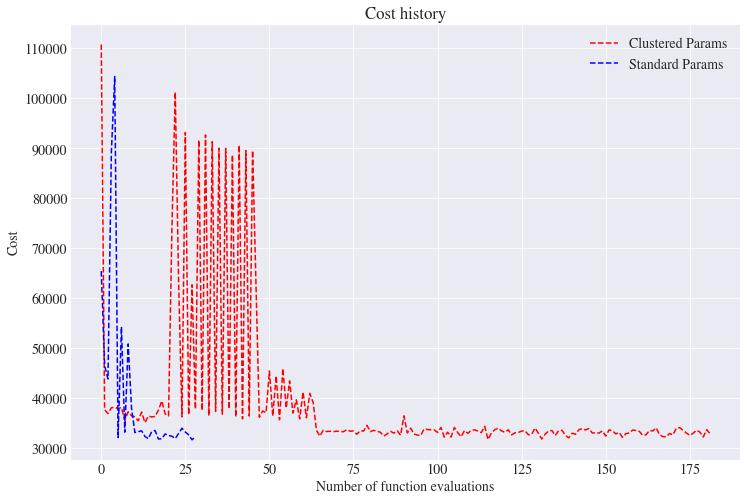

In [14]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
clustered_results.plot_cost(ax=ax,color='red',label='Clustered Params')
standard_results.plot_cost(ax=ax,color='blue',label='Standard Params')

In [15]:
opt_counts_clustered = clustered_results.optimized['optimized measurement outcomes']
opt_counts_standard = standard_results.optimized['optimized measurement outcomes']

In [16]:
sorted_counts_clustered = sort_counts_increasing_energy(cost_hamil,opt_counts_clustered)
sorted_counts_standard = sort_counts_increasing_energy(cost_hamil,opt_counts_standard)

In [18]:
energies_clustered = [bitstring_energy(cost_hamil,basis) for basis in sorted_counts_clustered.keys()]
energies_standard = [bitstring_energy(cost_hamil,basis) for basis in sorted_counts_standard.keys()]

Text(0, 0.5, 'sampling probability')

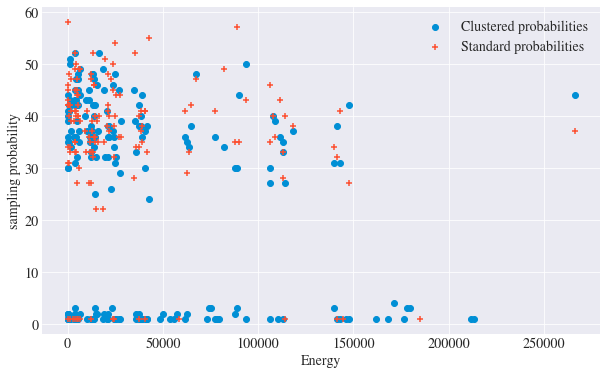

In [24]:
plt.figure(figsize=(10,6))
plt.scatter(energies_clustered, sorted_counts_clustered.values(), color="C0", label="Clustered probabilities")
plt.scatter(energies_standard, sorted_counts_standard.values(), marker="+", color="C1", label="Standard probabilities")
# plt.ylim([0.8,1])
plt.legend()
plt.xlabel("Energy")
plt.ylabel("sampling probability")
# plt.yscale("log")

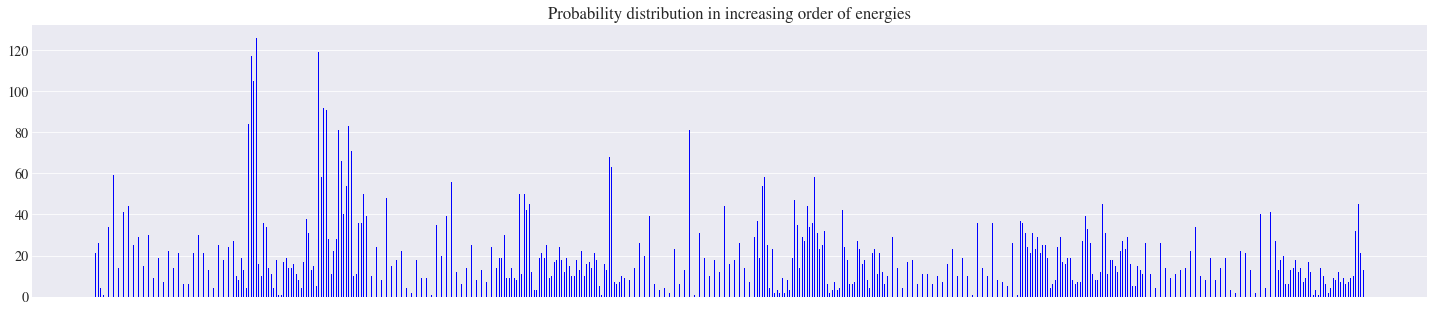

In [16]:
# Probability distribution for Standard Parameters
plot_counts(sort_counts_increasing_energy(cost_hamil,opt_counts_standard),False)

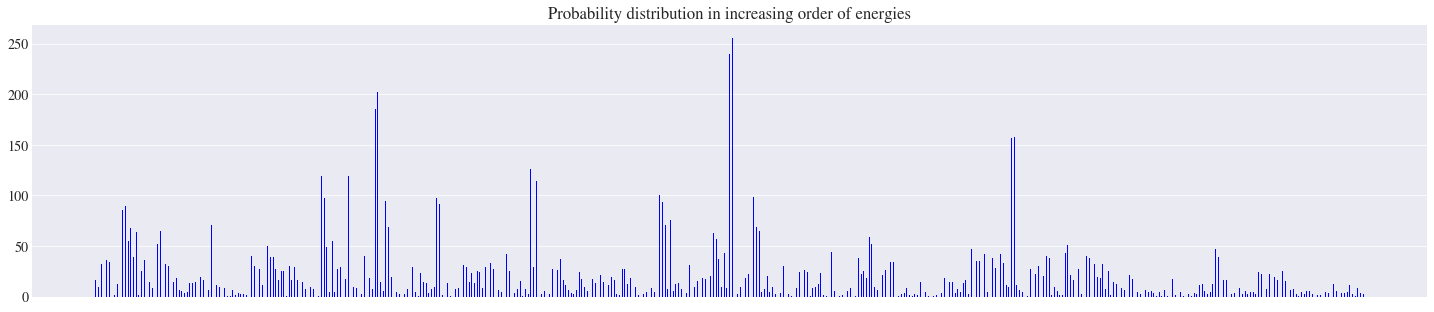

In [17]:
# Probability distribution for Clustered Parameters
plot_counts(sort_counts_increasing_energy(cost_hamil,opt_counts_clustered),False)

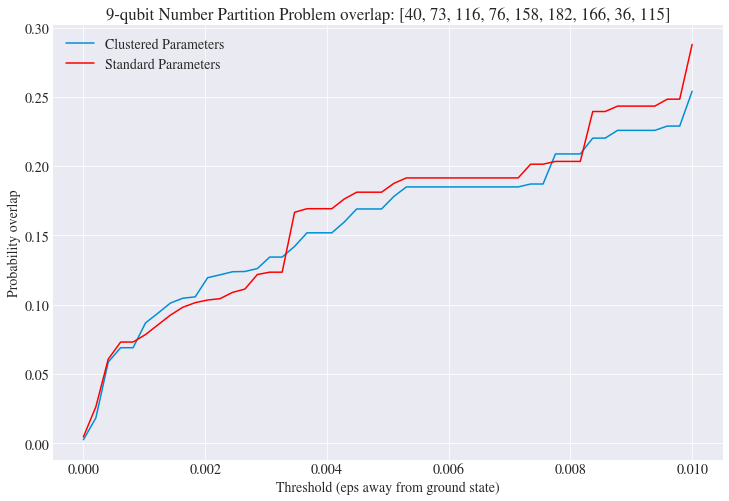

In [18]:
eps = np.linspace(0,0.01,50)
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, opt_counts_clustered) for ep in eps])
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, opt_counts_standard) for ep in eps],color='red')
plt.legend(['Clustered Parameters','Standard Parameters'])
plt.xlabel('Threshold (eps away from ground state)')
plt.ylabel('Probability overlap')
plt.title(f'9-qubit Number Partition Problem overlap: {nums}');
# plt.savefig(f'images/9-qubit Number Partition Problem overlap: {nums}.pdf')

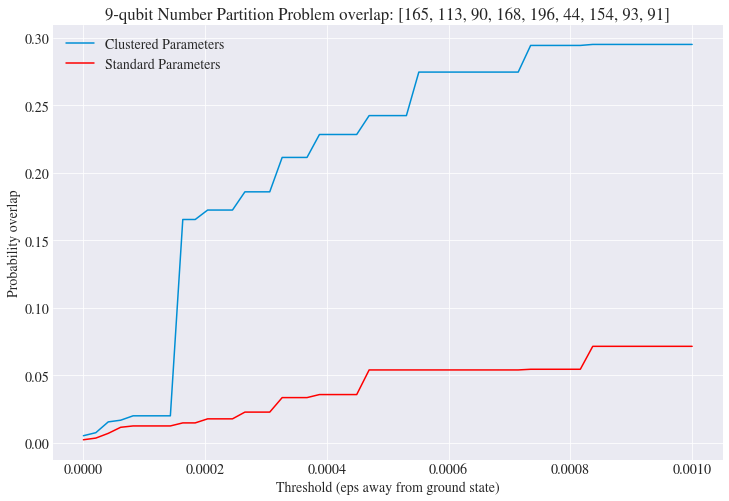

In [36]:
eps = np.linspace(0,0.001,50)
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, opt_counts_clustered) for ep in eps])
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, opt_counts_standard) for ep in eps],color='red')
plt.legend(['Clustered Parameters','Standard Parameters'])
plt.xlabel('Threshold (eps away from ground state)')
plt.ylabel('Probability overlap')
plt.title(f'9-qubit Number Partition Problem overlap: {nums}');
# plt.savefig(f'images/9-qubit Number Partition Problem overlap: {nums}.pdf')